## 1. Import required Libraries

In [91]:
# <<insert yout code here>>
import os 
import numpy as np
import tensorflow as tf

from sklearn.model_selection import KFold
from cleanlab.filter import find_label_issues
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt

## 2. Loading the Data

In [92]:
# <<insert yout code here>>
image_dir = './Images'

labels = []
data = []

allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
img_size = (150, 150)   

for label in os.listdir(image_dir):
    subfolder_path = os.path.join(image_dir, label)

    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            if any(image_file.lower().endswith(ext) for ext in allowed_extensions):
                try: 
                    image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=img_size)
                    image = np.array(image) / 255.0

                    labels.append(int(label[-1]) -1)
                    data.append(image)
                
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")


X_all = np.array(data)
y_all = np.array(labels)


print("Loaded images:", X_all.shape)
print("Loaded labels:", y_all.shape)

Loaded images: (8538, 150, 150, 3)
Loaded labels: (8538,)


## 3. Data Labelling Errors

In [93]:
# <<insert yout code here>>
# Temp model for cleanlab
def temp_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
    
    # unfreezes the last 30 layers so they can learn "Handwashing" specifics
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [94]:
# cross validation
from pyexpat import features


num_classes = len(np.unique(y_all))

pred_probs = np.zeros((len(X_all), num_classes))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_idx, val_idx in kf.split(X_all):
    model = temp_model(num_classes)
    history = model.fit(
        X_all[train_idx],
        y_all[train_idx],
        epochs=8,
        batch_size=16, 
        verbose=1 
    )

    val_loss, val_acc = model.evaluate(X_all[val_idx], y_all[val_idx], verbose=0)
    accuracies.append(val_acc)
    print(f"Fold {fold}/5 - Val Accuracy: {val_acc:.2%}")

    pred_probs[val_idx] = model.predict(X_all[val_idx], verbose=0)
    fold += 1

avg_acc = np.mean(accuracies)
print(f"\nAverage Model Accuracy: {avg_acc:.2%}")
print("Cross-validation complete!")


Epoch 1/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.2609 - loss: 1.9327
Epoch 2/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.4736 - loss: 1.4320
Epoch 3/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.6040 - loss: 1.0989
Epoch 4/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.7149 - loss: 0.8128
Epoch 5/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.7896 - loss: 0.6081
Epoch 6/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.8556 - loss: 0.4327
Epoch 7/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.8985 - loss: 0.3088
Epoch 8/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.9154 - loss: 0.2509
Fold 1/5 - Val Accuracy: 61.01%
Epoch 1/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.2656 - loss: 1.9258
Epoch 2/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.4687 - loss: 1.4342
Epoch 3/8
427/427 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.6035 - loss: 1.1143
Epoch 4/8
4

In [ ]:
# Identify label issues using Cleanlab
label_issues = find_label_issues(
    labels=y_all,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'
)

print("Number of suspected label errors:", len(label_issues))
label_issues[:20]


Number of suspected label errors: 2643


array([2133, 5388, 6923, 4451, 7084,  363, 2396, 6963, 4193, 3736, 5865,
       7536, 4390, 2253, 2574, 5667, 1521, 1466, 1085, 2210])

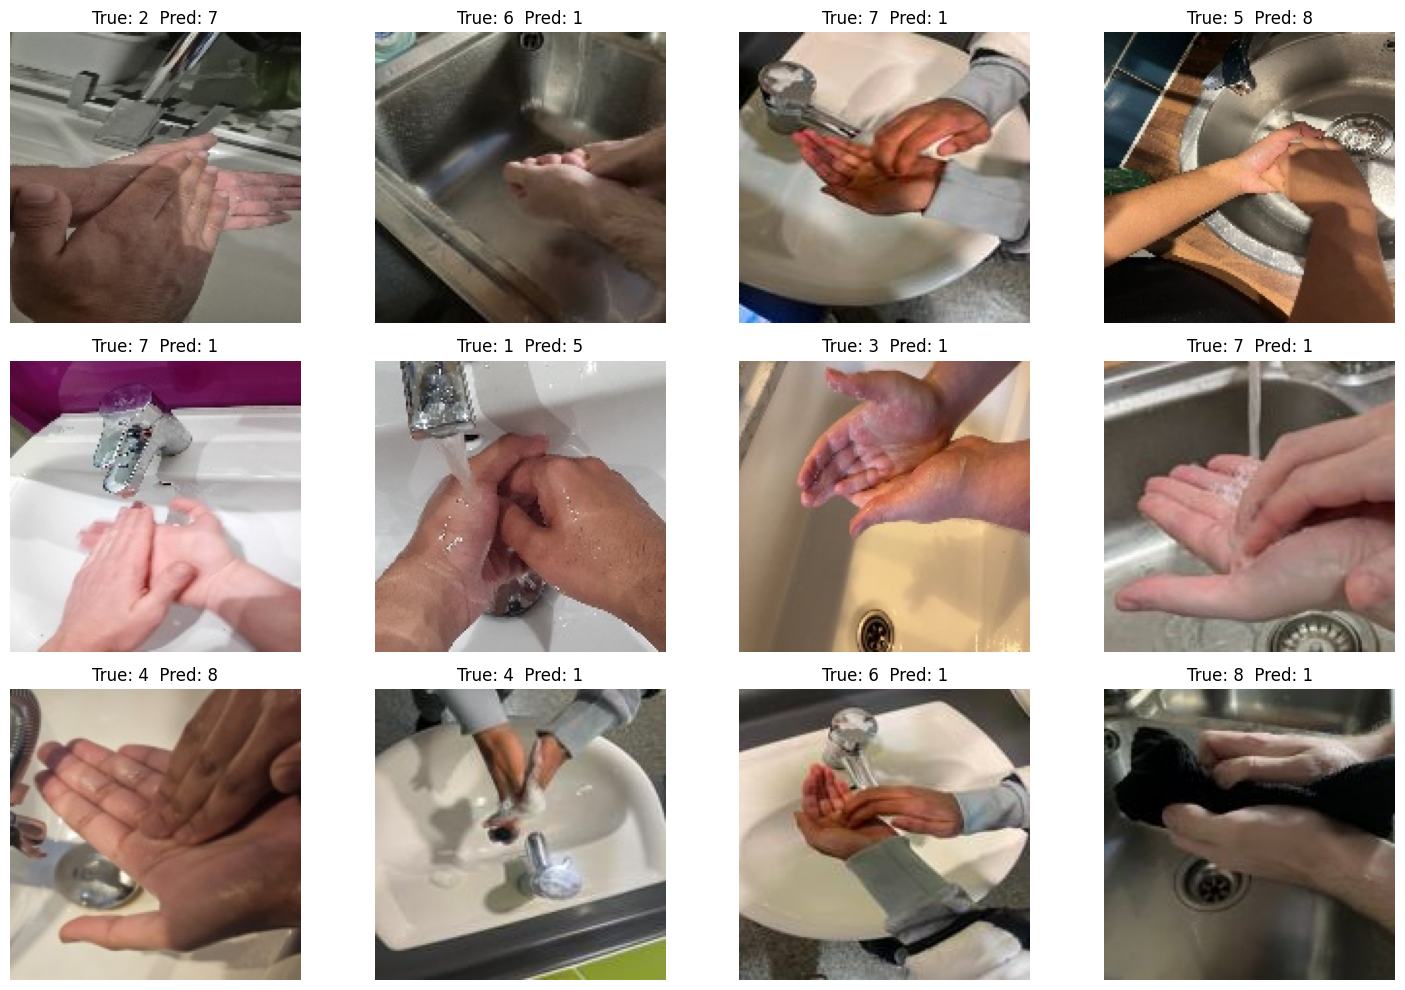

In [96]:
def show_issues(indices, n=12):
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(3,4,i+1)
        plt.imshow(X_all[idx])
        plt.axis('off')

        true_lbl = y_all[idx] + 1
        pred_lbl = np.argmax(pred_probs[idx]) + 1

        plt.title(f"True: {true_lbl}  Pred: {pred_lbl}")

    plt.tight_layout()
    plt.show()

show_issues(label_issues)


In [ ]:
# Deleting the skewed images
X_clean = np.delete(X_all, label_issues, axis=0)
y_clean = np.delete(y_all, label_issues, axis=0)

print(f"Original size: {len(X_all)}")
print(f"New size: {len(X_clean)}")

In [ ]:
from collections import Counter

# remove flagged samples
clean_indices = np.setdiff1d(np.arange(len(y_all)), label_issues)
y_cleaned = y_all[clean_indices]

# count samples per class
class_counts = Counter(y_cleaned)

for cls in sorted(class_counts.keys()):
    print(f"Stage {cls+1}: {class_counts[cls]}")


## Label errors:


<ol>
  <li>The method used</li>
  For identifying label issues, I used Cleanlab’s self-confidence method. Cleanlab works by comparing the model’s predicted probabilities with the provided labels and highlighting the images the model is least confident about.

  I tried several different modelling approaches, including both traditional ML and neural networks, and the highest accuracy I could achieve was around 61%. This suggested that the main problem wasn’t the choice of model but the data itself, many images are difficult to distinguish, even for a trained model.

  Because of this, instead of relying on Cleanlab to identify exact label mistakes, which requires a highly accurate model, I used it to detect ambiguous or unclear images. These are the samples the model consistently struggled with, and removing them helps improve overall data quality.

  <li>Explain what kind of errors you found in the dataset.</li>
  When I reviewed the top 20 lowest-confidence images, there was a mix of issues. Some genuinely had incorrect labels, but many were correctly labelled and the model’s prediction was wrong. This happened because the model’s accuracy was relatively low, so the probability scores Cleanlab relied on weren’t strong enough to clearly separate “bad labels” from “bad predictions.”

  A lot of these images were also simply unclear or ambiguous, similar stages, awkward angles, or low-quality samples that would confuse both the model and a human.

  So overall, the errors were a blend of real label mistakes and images the model couldn’t confidently classify, mainly due to the dataset’s ambiguity rather than the model itself.
  
  <li>List the total number of images left in each class/stage after the label error handling</li>
</ol>

<br>

<ol>
  <li>Stage 1: <<Number of images>></li>
  <li>Stage 2: <<Number of images>></li>
  <li>Stage 3: <<Number of images>></li>
  <li>Stage 4: <<Number of images>></li>
  <li>Stage 5: <<Number of images>></li>
  <li>Stage 6: <<Number of images>></li>
  <li>Stage 7: <<Number of images>></li>
  <li>Stage 8: <<Number of images>></li>
</ol>

## 4. Pre-process the Dataset

In [97]:
# <<insert yout code here>>

## 5. Split the data
<br>

Split the data into training, validation and testing dataset using Startification, ensuring equal class distribution.

Choose appropriate values of training, validation and testing datasets.

Display total number of images in each dataset split.

In [98]:
# <<insert yout code here>>

## 6. Model Implementation

In [99]:
# <<insert yout code here>>

## 7. Evaluate the Model

In [100]:
# <<insert yout code here>>

### Training Curves

In [101]:
# <<insert yout code here>>

### Make Inference
For some unseen data, make predictions using the trained model.

In [102]:
# <<insert yout code here>>